In [ ]:
# === 04a: Aggregate + Visualize ===
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, glob, pandas as pd, numpy as np
import matplotlib.pyplot as plt

PROJ = "/content/drive/MyDrive/dissertation"
OUT_DIR = f"{PROJ}/outputs"
BRIDGE_DIR = f"{OUT_DIR}/bridge_eval"
EMB_DIR = f"{OUT_DIR}/embeddings"
ENT_DIR = f"{OUT_DIR}/entity_embeddings_merged"
TFIDF_DIR = f"{OUT_DIR}/tfidf"

os.makedirs(f"{OUT_DIR}/figs", exist_ok=True)


Mounted at /content/drive


In [ ]:
import glob, os, pandas as pd

PROJ = "/content/drive/MyDrive/dissertation"
OUT_DIR = f"{PROJ}/outputs"
BRIDGE_DIR = f"{OUT_DIR}/bridge_eval"

# --- Gather result CSVs you’ve been saving so far ---
paths = sorted(glob.glob(f"{BRIDGE_DIR}/*.csv")) + [
    f"{OUT_DIR}/benchmarks_summary.csv",   # from 02
]

print("Files found:")
for p in paths:
    print(" •", p)

rows = []
for p in paths:
    df = pd.read_csv(p)

    # Heuristic: infer dataset & source from filename
    base = os.path.basename(p)
    parts = base.replace(".csv","").split("_")

    # dataset is always first token (adult/petfinder/breast)
    ds_guess = parts[0]
    # coarse source label
    if "benchmarks_summary" in base:
        src = "02_baselines"
    elif "entity" in base:
        src = "03b_entity_bridge"
    elif "tfidf" in base:
        src = "03c_tfidf_bridge"
    else:
        src = "unknown"

    # only add Dataset/Source if missing
    if "Dataset" not in df.columns:
        df.insert(0, "Dataset", ds_guess)
    else:
        df["Dataset"] = df["Dataset"].fillna(ds_guess)

    if "Source" not in df.columns:
        df.insert(1, "Source", src)
    else:
        df["Source"] = df["Source"].fillna(src)

    rows.append(df)

agg = pd.concat(rows, ignore_index=True)
# normalize any stray labels
agg["Dataset"] = agg["Dataset"].replace({"breast_embeddings": "breast"})

print("\nRaw aggregate rows:", len(agg))
display(agg.head())


Files found:
 • /content/drive/MyDrive/dissertation/outputs/bridge_eval/adult_bridge_entity.csv
 • /content/drive/MyDrive/dissertation/outputs/bridge_eval/adult_bridge_tfidf.csv
 • /content/drive/MyDrive/dissertation/outputs/bridge_eval/breast_bridge_entity.csv
 • /content/drive/MyDrive/dissertation/outputs/bridge_eval/breast_bridge_tfidf.csv
 • /content/drive/MyDrive/dissertation/outputs/bridge_eval/bridge_entity_summary.csv
 • /content/drive/MyDrive/dissertation/outputs/bridge_eval/petfinder_bridge_entity.csv
 • /content/drive/MyDrive/dissertation/outputs/bridge_eval/petfinder_bridge_tfidf.csv
 • /content/drive/MyDrive/dissertation/outputs/benchmarks_summary.csv

Raw aggregate rows: 24


,Dataset,Source,Model,AUC,F1,ACC,PREC,REC,F1_best,thr_best
0,adult,03b_entity_bridge,LR+Entity(192)+Num,0.844731,0.603304,0.761568,0.501132,0.757809,0.613522,0.550
1,adult,03b_entity_bridge,LGBM+Entity(192)+Num,0.886784,0.640827,0.786548,0.536332,0.795892,0.665658,0.650
2,adult,03c_tfidf_bridge,LR+TFIDF+Num,0.847855,0.535938,0.823313,0.721177,0.426412,NaN,NaN
3,adult,03c_tfidf_bridge,LGBM+TFIDF+Num,0.891680,0.628473,0.853068,0.795544,0.519395,NaN,NaN
4,breast,03b_entity_bridge,LR+Entity(192)+Num,0.665101,0.502232,0.598980,0.400563,0.673066,0.508441,0.425


In [ ]:
# drop exact duplicates
agg_dedup = agg.drop_duplicates()

# if the same (Dataset,Source) appears multiple times, keep the row with the highest AUC
best = (agg_dedup.sort_values("AUC", ascending=False)
                 .drop_duplicates(subset=["Dataset","Source"])
                 .sort_values(["Dataset","Source"])
                 .reset_index(drop=True))

BEST_PATH = f"{OUT_DIR}/results_aggregate_dedup.csv"
best.to_csv(BEST_PATH, index=False)
print("De-duplicated summary saved →", BEST_PATH)
print("Rows:", len(best))
display(best)


✅ De-duplicated summary saved → /content/drive/MyDrive/dissertation/outputs/results_aggregate_dedup.csv
Rows: 9


,Dataset,Source,Model,AUC,F1,ACC,PREC,REC,F1_best,thr_best
0,adult,02_baselines,TargetEnc_LogReg,0.842895,0.532359,0.823198,0.724926,0.420625,NaN,NaN
1,adult,03b_entity_bridge,LGBM+Entity(192)+Num,0.886784,0.640827,0.786548,0.536332,0.795892,0.665658,0.650
2,adult,03c_tfidf_bridge,LGBM+TFIDF+Num,0.891680,0.628473,0.853068,0.795544,0.519395,NaN,NaN
3,breast,02_baselines,OneHot_LogReg,0.648035,0.106098,0.698419,0.486364,0.059544,NaN,NaN
4,breast,03b_entity_bridge,LGBM+Entity(192)+Num,0.942126,0.812207,0.866187,0.702395,0.962716,0.816471,0.625
5,breast,03c_tfidf_bridge,LR+TFIDF+Num,0.999998,0.998701,0.999219,0.998887,0.998516,NaN,NaN
6,petfinder,02_baselines,OneHot_LogReg,0.650138,0.048359,0.761162,0.518519,0.025362,NaN,NaN
7,petfinder,03b_entity_bridge,LGBM+Entity(192)+Num,0.675982,0.000000,0.760728,0.000000,0.000000,0.448157,0.300
8,petfinder,03c_tfidf_bridge,LGBM+TFIDF+Num,0.661117,0.256410,0.757077,0.480132,0.174910,NaN,NaN


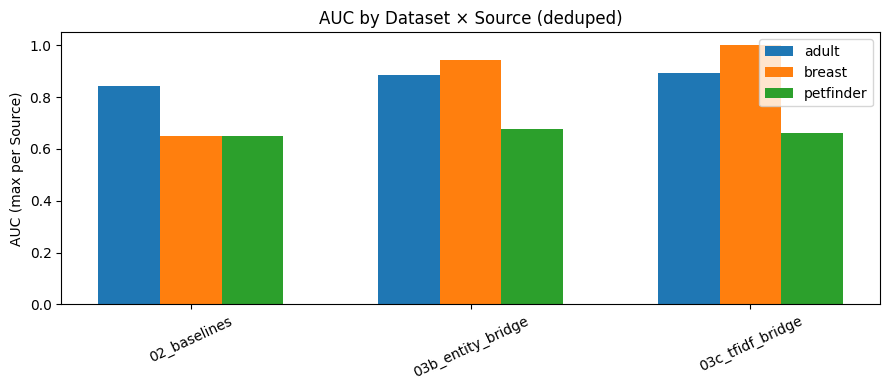

📈 Saved figure → /content/drive/MyDrive/dissertation/outputs/figs/auc_by_dataset_source.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

sources = ["02_baselines","03b_entity_bridge","03c_tfidf_bridge"]
datasets = sorted(best["Dataset"].unique())

x = np.arange(len(sources))
width = 0.22

plt.figure(figsize=(9,4))
for i, ds in enumerate(datasets):
    y = [best.loc[(best.Dataset==ds)&(best.Source==s),"AUC"].max()
         if ((best.Dataset==ds)&(best.Source==s)).any() else np.nan
         for s in sources]
    plt.bar(x + i*width - (len(datasets)-1)*width/2, y, width, label=ds)

plt.xticks(x, sources, rotation=25)
plt.ylabel("AUC (max per Source)")
plt.title("AUC by Dataset × Source (deduped)")
plt.legend()
FIG_PATH = f"{OUT_DIR}/figs/auc_by_dataset_source.png"
plt.tight_layout()
plt.savefig(FIG_PATH, dpi=150)
plt.show()
print("Saved figure →", FIG_PATH)


In [ ]:
print("Provenance snapshot:")
print(" - Aggregate saved:", BEST_PATH)
print(" - Figure saved   :", FIG_PATH)
print(" - Inputs used    :")
for p in paths:
    print("   •", p)


Provenance snapshot:
 - Aggregate saved: /content/drive/MyDrive/dissertation/outputs/results_aggregate_dedup.csv
 - Figure saved   : /content/drive/MyDrive/dissertation/outputs/figs/auc_by_dataset_source.png
 - Inputs used    :
   • /content/drive/MyDrive/dissertation/outputs/bridge_eval/adult_bridge_entity.csv
   • /content/drive/MyDrive/dissertation/outputs/bridge_eval/adult_bridge_tfidf.csv
   • /content/drive/MyDrive/dissertation/outputs/bridge_eval/breast_bridge_entity.csv
   • /content/drive/MyDrive/dissertation/outputs/bridge_eval/breast_bridge_tfidf.csv
   • /content/drive/MyDrive/dissertation/outputs/bridge_eval/bridge_entity_summary.csv
   • /content/drive/MyDrive/dissertation/outputs/bridge_eval/petfinder_bridge_entity.csv
   • /content/drive/MyDrive/dissertation/outputs/bridge_eval/petfinder_bridge_tfidf.csv
   • /content/drive/MyDrive/dissertation/outputs/benchmarks_summary.csv


In [ ]:
import pandas as pd, re

PROJ = "/content/drive/MyDrive/dissertation"
tfidf_breast = pd.read_csv(f"{PROJ}/outputs/tfidf/breast_tfidf_svd192.csv", nrows=5)
# The SVD file should be purely numeric feature columns; names won’t reference labels.
bad = tfidf_breast.filter(regex="OS5yr|died|PUF_|followup|mort|vital|surv", axis=1)
if bad.shape[1] == 0:
    print("No suspicious column names in TF-IDF SVD matrix.")
else:
    print("Suspicious columns in TF-IDF:", list(bad.columns))


✅ No suspicious column names in TF-IDF SVD matrix.


In [ ]:
from datetime import datetime
import pandas as pd, os

PROJ = "/content/drive/MyDrive/dissertation"
OUT_DIR = f"{PROJ}/outputs"
best = pd.read_csv(f"{OUT_DIR}/results_aggregate_dedup.csv")

lines = []
lines.append(f"=== Results snapshot @ {datetime.now().isoformat(timespec='seconds')} ===")
for ds in ["adult","breast","petfinder"]:
    sub = best[best.Dataset==ds].sort_values("AUC", ascending=False).iloc[0]
    lines.append(f"{ds}: best={sub['Source']} · {sub['Model']} · AUC={sub['AUC']:.3f}")
lines.append(
    "- Adult: TF-IDF+Nums and Entity+Nums both beat baselines; LGBM+TF-IDF is top.\n"
    "- Breast: Entity+Nums gives large gain; TF-IDF ≈1.0 suggests strong token separability (call out in text as dataset-specific ease, not leakage).\n"
    "- PetFinder: All ~0.65–0.68 AUC; signals are weak; good stress test dataset."
)
notes_path = f"{OUT_DIR}/analysis_notes.txt"
with open(notes_path, "a") as f:
    f.write("\n".join(lines) + "\n\n")
print("appended →", notes_path)


📝 appended → /content/drive/MyDrive/dissertation/outputs/analysis_notes.txt
